In [1]:
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from collections import defaultdict
from scipy.stats import norm
import matplotlib.pyplot as plt
import operator
import time
import numpy as np
np.random.seed(1)

# Generate Data

In [2]:
percentageTest = .2 # percentage of dataset to be designated as the test data

# Function to return gaussian data with given means, covariances, and number of points per class
# Returns 4 parameters: trainingData, testingData, trainingLabels, testingLabels
def generateGaussianData(mean1, mean2, cov1, cov2, pointsPerLabel):
    gauss1 = np.random.multivariate_normal(mean1, cov1, pointsPerLabel)
    labels1 = np.full(pointsPerLabel, -1, dtype=np.float64)
    gauss2 = np.random.multivariate_normal(mean2, cov2, pointsPerLabel)
    labels2 = np.full(pointsPerLabel, 1, dtype=np.float64)

    dataset = np.concatenate((gauss1, gauss2), axis=0)
    labels = np.concatenate((labels1, labels2), axis=0)
    
    plotRawData(dataset, labels)

    return train_test_split(dataset, labels, test_size=percentageTest, random_state=42)

In [3]:
# Function to plot the raw data
def plotRawData(dataset, labels):
    feature1 = dataset[:, 0]
    feature2 = dataset[:, 1]
    plt.scatter(feature1, feature2, c=labels, cmap=plt.cm.coolwarm, s=20)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Raw Data")

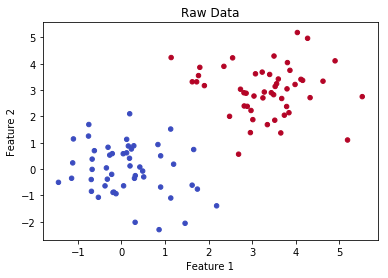

In [4]:
# Generate Gaussian data
mean1 = [0,0]
cov1 = [[1,0],[0,1]]
mean2 = [3,3]
cov2 = [[1,0],[0,1]]
dataSize = 50
trainingData, testingData, trainingLabels, testingLabels = generateGaussianData(mean1, mean2, cov1, cov2, dataSize)

# Naive Bayes
### Naive Bayes Implementation using:
- Parameters for each feature within a label are independent of other features
- Assumes continuous input and normal densities

In [5]:
# Class representing a distribution of a single feature within a class label
class FeatureDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

In [6]:
# Class to hold all label and feature distribution information for the training data
class DataDistributions:
    def __init__(self):
        self.labelsDistributions = {} # dictionary to store feature distribution information for each label
        
    # Adds distribution information for a label
    def addLabelDistribution(self, label, distributions):
        self.labelsDistributions[label] = distributions

    # For a given datapoint, calculates the probabilities for a datapoint belonging to each label
    # Returns a dictionary of labels to probabilities
    def getLabelProbabilities(self, datapoint):
        labelProbabilities = {}
        for label in self.labelsDistributions.keys():
            labelProbabilities[label] = CalculatePointProbabilityGivenDistributions(datapoint, self.labelsDistributions[label])
        return labelProbabilities

In [7]:
class NaiveBayesModel:

    def __init__(self):
        self.dataDistributions = None
    
    # Calculate label distributions
    def train(self, trainData, trainLabels):
        self.dataDistributions = CalculateDataDistributions(trainData, trainLabels)
        
    def test(self, testData, testLabels):
        if self.dataDistributions is None:
            raise RunTimeError('You must train the model before testing')
            
        predictions = list(map(lambda testDatapoint:  NaiveBayes(self.dataDistributions, testDatapoint), testData))
        accuracy = accuracy_score(testLabels.tolist(), predictions)
        return accuracy

In [16]:
# Applies Naive Bayes algorithm for a specific datapoint
# Returns best label for the given point
def NaiveBayes(labelsDistributions, datapoint):
    labelProbabilities = labelsDistributions.getLabelProbabilities(datapoint)
    # Sort by probabilities
    labelProbabilitiesSorted = sorted(labelProbabilities.items(), key=operator.itemgetter(1), reverse=True)
    biggestLabelAndProbability = labelProbabilitiesSorted[0]
    bestLabel = biggestLabelAndProbability[0]
    return bestLabel

In [9]:
# Calculate data distributions for each label
# Returns a DataDistributions object
def CalculateDataDistributions(data, labels):
    labelsDistributions = DataDistributions()
    for label in set(labels):
        labelData = data[np.where(labels == label)] 
        labelDistributions = CalculateLabelDistributions(labelData)
        labelsDistributions.addLabelDistribution(label, labelDistributions)
    return labelsDistributions

In [10]:
# Calculate distributions for a given label
# Returns list of FeatureDistribution objects
def CalculateLabelDistributions(labelData):
    labelDistributions = []
    for featureIndex in range(np.shape(labelData)[1]): # For each feature
        featureDistribution = CalculateDistributionForFeature(labelData[:,featureIndex])
        labelDistributions.append(featureDistribution)
    return labelDistributions

In [11]:
# Calculates feature distribution for the given data
# If this were categorical data, this function could be replaced by one that calculates probability based on counts
# Returns FeatureDistribution object
def CalculateDistributionForFeature(data):
    mu = np.mean(data)
    sigma = np.var(data)
    return FeatureDistribution(mu, sigma)

In [12]:
# Calculates the probability of a point given a list of distribution parameters
# Returns probability
def CalculatePointProbabilityGivenDistributions(datapoint, distributions):
    totalProbability = 1
    for featureIndex, feature in enumerate(datapoint):
        distribution = distributions[featureIndex]
        featureProbability = norm.pdf(datapoint[featureIndex], distribution.mu, distribution.sigma)
        totalProbability = totalProbability * featureProbability
    return totalProbability

# Run The Model

In [18]:
model = NaiveBayesModel()
model.train(trainingData, trainingLabels)
print(model.test(testingData, testingLabels))

1.0
